<a href="https://colab.research.google.com/github/mariajmolina/UMDAOSC650/blob/main/firstcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Maintained at: https://github.com/mariajmolina/UMDAOSC650/blob/main/firstcnn.ipynb

# Our first convolutional neural network (CNN)!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import keras
from keras import layers

We will use a dataset from Molina et al. (2021) consisting of thunderstorms generated using a 4-km horizontal resolution WRF simulation. We are using a small portion of the dataset, specifically thunderstorms simulated for April 27, 2011 over the continental United States.

In [ ]:
!wget https://zenodo.org/records/10576726/files/current_SP3hourly_20110427.nc

--2025-11-26 22:36:09--  https://zenodo.org/records/10576726/files/current_SP3hourly_20110427.nc
Resolving zenodo.org (zenodo.org)... 188.185.48.75, 188.185.43.153, 137.138.52.235, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109400556 (104M) [application/octet-stream]
Saving to: ‘current_SP3hourly_20110427.nc’

current_SP3hourly_2 100%[===================>] 104.33M  27.6MB/s    in 4.4s    

2025-11-26 22:36:14 (23.4 MB/s) - ‘current_SP3hourly_20110427.nc’ saved [109400556/109400556]



Here we have some helper functions for normalizing and standardizing our data using numpy.

In [ ]:
def scale_da_along_dim(
    da: xr.DataArray,
    dim: str = "feature",
    scaler=None,
    method: str = "standard",
    with_mean: bool = True,
    with_std: bool = True,
    feature_range=(0.0, 1.0),
):
    """
    Scale an xarray.DataArray along one dimension using sklearn,
    preserving xarray metadata and avoiding stack/unstack (duplicates OK).

    All dimensions except `dim` are treated as samples. One global scaler
    is fit across the entire array (per-feature statistics).

    Parameters
    ----------
    da : xr.DataArray
        Input data.
    dim : str
        Name of the feature dimension (e.g. "feature").
    scaler : sklearn transformer or None
        If None, a new scaler is created based on `method`.
        If provided, it is used for transform only (no re-fit).
        Must implement `.transform()` / `.fit_transform()`.
    method : {"standard", "minmax"}
        - "standard" -> sklearn.preprocessing.StandardScaler
        - "minmax"   -> sklearn.preprocessing.MinMaxScaler
    with_mean, with_std : bool
        Used only when method="standard" and scaler is None.
    feature_range : tuple
        Used only when method="minmax" and scaler is None.

    Returns
    -------
    da_scaled : xr.DataArray
        Same shape/dims/coords/attrs as `da`, scaled along `dim`.
    scaler : sklearn transformer
        The fitted scaler.
    """
    # 1) Make sure `dim` exists
    if dim not in da.dims:
        raise ValueError(f"Dimension {dim!r} not found in DataArray dims {da.dims!r}")

    # 2) Put `dim` last
    da_t = da.transpose(..., dim)
    feature_axis = da_t.get_axis_num(dim)  # should be -1

    # 3) Extract ndarray and move feature axis to last (for safety)
    data = da_t.values
    data_moved = np.moveaxis(data, feature_axis, -1)  # shape: (*sample_shape, n_features)

    # 4) Flatten all non-feature dims into samples
    orig_shape = data_moved.shape
    n_features = orig_shape[-1]
    n_samples = int(np.prod(orig_shape[:-1]))
    data_flat = data_moved.reshape(n_samples, n_features)  # (n_samples, n_features)

    # 5) Fit/transform with chosen scaler
    if scaler is None:
        if method == "standard":
            scaler = StandardScaler(with_mean=with_mean, with_std=with_std)
        elif method == "minmax":
            scaler = MinMaxScaler(feature_range=feature_range)
        else:
            raise ValueError("method must be 'standard' or 'minmax'")

        data_flat_scaled = scaler.fit_transform(data_flat)
    else:
        # reuse provided scaler
        data_flat_scaled = scaler.transform(data_flat)

    # 6) Reshape back and restore axes
    data_scaled_moved = data_flat_scaled.reshape(orig_shape)
    data_scaled_full = np.moveaxis(data_scaled_moved, -1, feature_axis)

    # 7) Wrap back into DataArray
    da_scaled_t = xr.DataArray(
        data_scaled_full,
        coords=da_t.coords,
        dims=da_t.dims,
        attrs=da.attrs,
        name=da.name,
    )

    # 8) Restore original dim order
    da_scaled = da_scaled_t.transpose(*da.dims)

    return da_scaled, scaler

def inverse_scale_da_along_dim(
    da_scaled: xr.DataArray,
    dim: str,
    scaler,
) -> xr.DataArray:
    """
    Inverse of `scale_da_along_dim`: apply scaler.inverse_transform and
    reconstruct the original DataArray with metadata.

    Works with any sklearn-like scaler that implements `inverse_transform`,
    e.g., StandardScaler or MinMaxScaler.
    """
    if dim not in da_scaled.dims:
        raise ValueError(f"Dimension {dim!r} not found in DataArray dims {da_scaled.dims!r}")

    # 1) Put `dim` last
    da_t = da_scaled.transpose(..., dim)
    feature_axis = da_t.get_axis_num(dim)

    # 2) Move feature axis to last and flatten other dims
    data = da_t.values
    data_moved = np.moveaxis(data, feature_axis, -1)
    orig_shape = data_moved.shape
    n_features = orig_shape[-1]
    n_samples = int(np.prod(orig_shape[:-1]))

    data_flat = data_moved.reshape(n_samples, n_features)

    # 3) Inverse transform
    data_flat_unscaled = scaler.inverse_transform(data_flat)

    # 4) Reshape back and restore axes
    data_unscaled_moved = data_flat_unscaled.reshape(orig_shape)
    data_unscaled_full = np.moveaxis(data_unscaled_moved, -1, feature_axis)

    # 5) Wrap into DataArray and restore original dim order
    da_unscaled_t = xr.DataArray(
        data_unscaled_full,
        coords=da_t.coords,
        dims=da_t.dims,
        attrs=da_scaled.attrs,
        name=da_scaled.name,
    )
    da_unscaled = da_unscaled_t.transpose(*da_scaled.dims)
    return da_unscaled

## **Supervised Learning Regression Example**

Now, we will proceed with training a neural network in a supervised learning regression application.

Let's visualize the dataset. We can use python libraries for this.

In [ ]:
ds = xr.open_dataset('current_SP3hourly_20110427.nc')

In [ ]:
ds

<xarray.Dataset> Size: 109MB
Dimensions:      (starttime: 2224, y: 32, x: 32)
Coordinates:
  * starttime    (starttime) float64 18kB 9.264e+04 9.264e+04 ... 9.266e+04
    endtime      (starttime) float64 18kB ...
    x_speed      (starttime) int64 18kB ...
    y_speed      (starttime) int64 18kB ...
Dimensions without coordinates: y, x
Data variables:
    uh25_grid    (starttime, y, x) float32 9MB ...
    uh03_grid    (starttime, y, x) float32 9MB ...
    ctt_grid     (starttime, y, x) float32 9MB ...
    dbz_grid     (starttime, y, x) float32 9MB ...
    mask         (starttime, y, x) int64 18MB ...
    row_indices  (starttime, y, x) int64 18MB ...
    col_indices  (starttime, y, x) int64 18MB ...
    lats         (starttime, y, x) float32 9MB ...
    lons         (starttime, y, x) float32 9MB ...

The dataset contains 2,224 storm samples that were generated using the github reposity [deep-conus](https://github.com/mariajmolina/deep-conus). Each sample is 32x32 grid cells (i.e., pixels) with each grid cell spanning 4-km.

Let's visualize some of the variables.

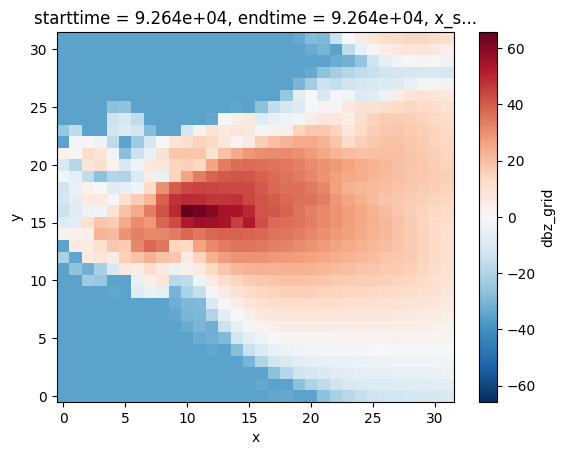

In [ ]:
# simulated radar reflectivity
ds['dbz_grid'].isel(starttime=0).plot()

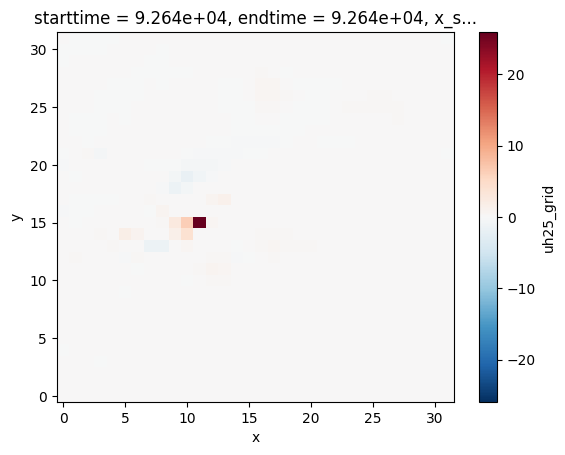

In [ ]:
# gridded updraft helicity from 2-5 km
ds['uh25_grid'].isel(starttime=0).plot()

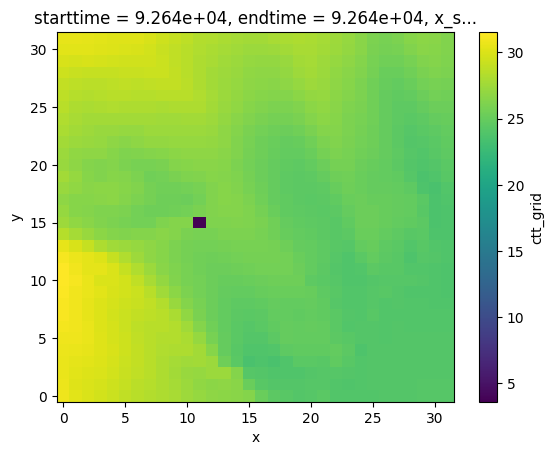

In [ ]:
# gridded cloud top temperature
ds['ctt_grid'].isel(starttime=0).plot()

Now we will preprocess our training and testing data. We need to split our data into a training and testing sets, and standardize.

In [ ]:
# first contactenate multiple feature into one new array along a dim
tmp_dbz = ds['dbz_grid'].expand_dims(dim='feature', axis=3)
tmp_ctt = ds['ctt_grid'].expand_dims(dim='feature', axis=3)

features = xr.concat([tmp_dbz, tmp_ctt], dim='feature')

In [ ]:
print(features.shape) # samples, x, y, features

(2224, 32, 32, 2)


In [ ]:
# grab the maximum of the dbz to use as our labels (regression)
labels = ds['dbz_grid'].expand_dims(dim='feature', axis=3).max('x').max('y')

In [ ]:
labels

<xarray.DataArray 'dbz_grid' (starttime: 2224, feature: 1)> Size: 9kB
array([[65.721054],
       [58.54062 ],
       [58.54062 ],
       ...,
       [45.41483 ],
       [37.786957],
       [42.48563 ]], dtype=float32)
Coordinates:
  * starttime  (starttime) float64 18kB 9.264e+04 9.264e+04 ... 9.266e+04
    endtime    (starttime) float64 18kB ...
    x_speed    (starttime) int64 18kB ...
    y_speed    (starttime) int64 18kB ...
Dimensions without coordinates: feature

In [ ]:
features

<xarray.DataArray 'dbz_grid' (starttime: 2224, y: 32, x: 32, feature: 2)> Size: 18MB
array([[[[-35.        ,  30.846277  ],
         [-35.        ,  30.279108  ],
         [-35.        ,  29.919764  ],
         ...,
         [-11.190116  ,  24.125116  ],
         [-10.856109  ,  24.160944  ],
         [-10.487292  ,  24.194544  ]],

        [[-35.        ,  30.6896    ],
         [-35.        ,  30.205988  ],
         [-35.        ,  29.94436   ],
         ...,
         [ -7.7814693 ,  24.12179   ],
         [ -7.321682  ,  24.138666  ],
         [ -6.878763  ,  24.156153  ]],

        [[-35.        ,  30.631739  ],
         [-35.        ,  30.26684   ],
         [-35.        ,  30.094019  ],
         ...,
...
         ...,
         [ 33.900024  ,   6.4582763 ],
         [ 32.759426  ,   6.7443175 ],
         [ 25.732063  ,   6.800195  ]],

        [[ 15.411227  ,  11.729609  ],
         [ 15.097066  ,  11.5689945 ],
         [ 25.667683  ,  11.157282  ],
         ...,
         [ 30.886953  ,   6.4143615 ],
         [ 28.967316  ,   6.7860045 ],
         [ 26.899176  ,   6.865045  ]],

        [[ 14.829235  ,  11.844446  ],
         [ 16.460741  ,  11.534296  ],
         [ 27.397823  ,  11.142817  ],
         ...,
         [ 25.714262  ,   6.4862304 ],
         [ 23.523518  ,   6.860742  ],
         [ 26.171114  ,   6.9690795 ]]]], dtype=float32)
Coordinates:
  * starttime  (starttime) float64 18kB 9.264e+04 9.264e+04 ... 9.266e+04
    endtime    (starttime) float64 18kB 9.264e+04 9.264e+04 ... 9.266e+04
    x_speed    (starttime) int64 18kB 0 0 0 0 0 0 0 0 ... -28 -4 -20 1 11 15 3 1
    y_speed    (starttime) int64 18kB 0 0 0 0 0 0 0 0 ... 17 21 -1 -9 30 13 -3
Dimensions without coordinates: y, x, feature

In [ ]:
# make features, x, and y into one column, so that data is (samples, newdim) for train/test split func to work
features_1d = features.stack(newdim=['x','y','feature'])

In [ ]:
features_1d.shape

(2224, 2048)

In [ ]:
labels.shape

(2224, 1)

In [ ]:
# now split train and test data
X_train, X_test, y_train, y_test = train_test_split(features_1d, labels, test_size=0.33, random_state=42)

In [ ]:
print(X_train.shape[0], X_test.shape[0], y_train.shape[0], y_test.shape[0]) # quick check

1490 734 1490 734


In [ ]:
print(X_train.shape, X_test.shape,)

(1490, 2048) (734, 2048)


In [ ]:
# unstack the stacked x, y, features dimensions
X_train = X_train.unstack()
X_test = X_test.unstack()

In [ ]:
print(X_train.shape, X_test.shape,) # back to original

(1490, 32, 32, 2) (734, 32, 32, 2)


In [ ]:
# standardize data
X_train_scaled, scaler_X = scale_da_along_dim(X_train, dim="feature")
X_test_scaled, _ = scale_da_along_dim(X_test, dim="feature", scaler=scaler_X)

y_train_scaled, scaler_Y = scale_da_along_dim(y_train, dim="feature")
y_test_scaled, _ = scale_da_along_dim(y_test, dim="feature", scaler=scaler_Y)

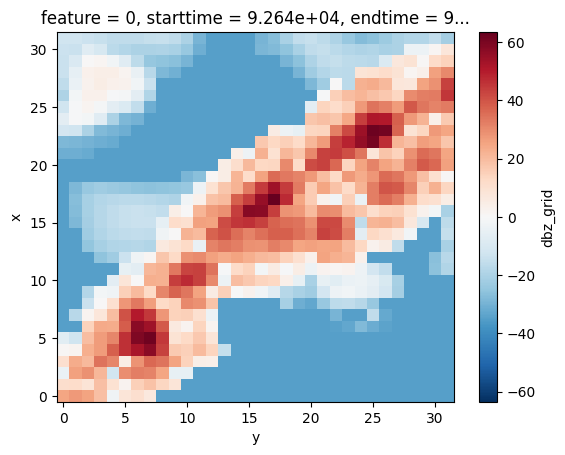

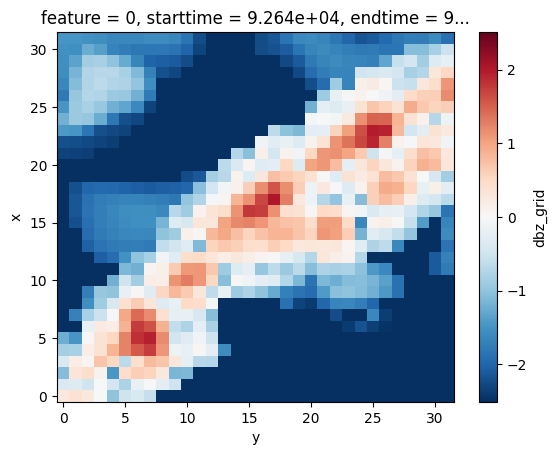

In [ ]:
X_train.isel(starttime=10, feature=0).plot(); plt.show() # quick check
X_train_scaled.isel(starttime=10, feature=0).plot(); plt.show() # quick check

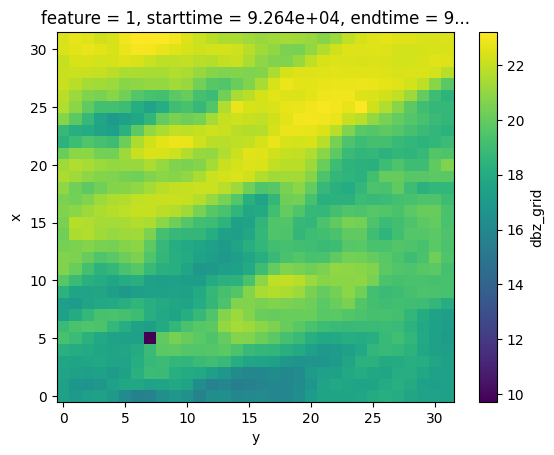

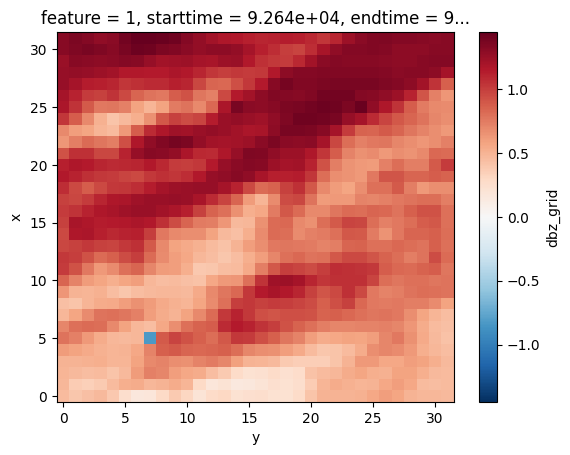

In [ ]:
X_train.isel(starttime=10, feature=1).plot(); plt.show() # quick check
X_train_scaled.isel(starttime=10, feature=1).plot(); plt.show() # quick check

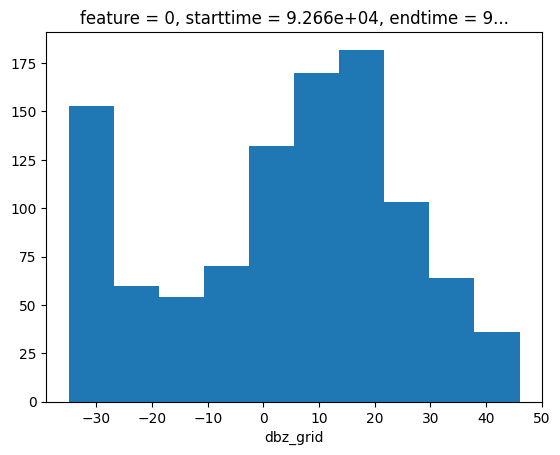

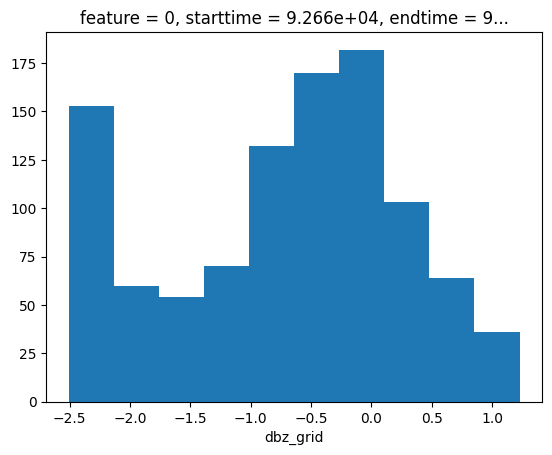

In [ ]:
X_train.isel(feature=0,starttime=15).plot.hist(); plt.show()
X_train_scaled.isel(feature=0,starttime=15).plot.hist(); plt.show()

Let's proceed to build a simple convolutional neural network that will take images as the input and predict the respective storm's maximum updraft helicity.

In [ ]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(12)

In [ ]:
# lets use two input variables (dbz_grid and ctt_grid)
number_of_features = 2

In [ ]:
model = keras.Sequential()

# input
model.add(keras.Input(shape=(32, 32, number_of_features)))  # 32x32 images

# data augmentation layers
model.add(layers.RandomFlip("horizontal_and_vertical"))
model.add(layers.RandomRotation(factor=(-0.5, 0.5)))

# hidden layers
model.add(layers.Conv2D(filters=16, kernel_size=(3,3), strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(filters=32, kernel_size=(3,3), strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(filters=64, kernel_size=(3,3), strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.2))

# Now that we have 4x4 feature maps, now apply global max pooling.
model.add(layers.GlobalMaxPooling2D())

# Finally, we add last fully connected (dense) layers
model.add(layers.Dense(32))
model.add(layers.Dense(1, activation="linear"))

# print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 32, 32, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 32, 32, 2)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,553 (99.82 KB)

 Trainable params: 25,553 (99.82 KB)

 Non-trainable params: 0 (0.00 B)

Proceeding with compiling our model and selecting some metrics to use.

Some common evaluation metrics used with regression problems are:

Mean absolute error (MAE): $\frac{1}{N} \sum\limits_{i = 1}^{N} \lvert \hat{y}_i - y_i \rvert$

Mean squared error (MSE): $\frac{1}{N} \sum\limits_{i = 1}^{N} (\hat{y}_i - y_i)^2$


More evalution metrics can be found [here](https://keras.io/api/metrics/regression_metrics/#meansquarederror-class).

In [ ]:
METRICS = [
    keras.metrics.MeanSquaredError(name='mean_squared_error'),
    keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),
    keras.metrics.MeanAbsoluteError(name="mean_absolute_error"),
]

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mean_squared_error",
    metrics=METRICS
)

In [ ]:
BATCH_SIZE = 32
EPOCHS = 20

In [ ]:
history = model.fit(
    x=X_train_scaled.values,
    y=y_train_scaled.values,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    shuffle=True,
)

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 1.9424 - mean_absolute_error: 1.0109 - mean_squared_error: 1.9424 - root_mean_squared_error: 1.3414 - val_loss: 0.7048 - val_mean_absolute_error: 0.6761 - val_mean_squared_error: 0.7048 - val_root_mean_squared_error: 0.8395
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.5942 - mean_absolute_error: 0.6210 - mean_squared_error: 0.5942 - root_mean_squared_error: 0.7706 - val_loss: 0.6271 - val_mean_absolute_error: 0.6432 - val_mean_squared_error: 0.6271 - val_root_mean_squared_error: 0.7919
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.5122 - mean_absolute_error: 0.5745 - mean_squared_error: 0.5122 - root_mean_squared_error: 0.7154 - val_loss: 0.5106 - val_mean_absolute_error: 0.5723 - val_mean_squared_error: 0.5106 - val_root_mean_squared_error: 0.7146
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.4076 - mean_absolute_error: 0.5065 - mean_squared_error: 0.4076 - root_mean_squared_error:

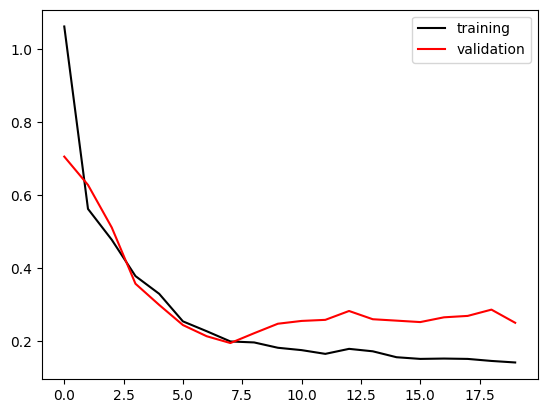

In [ ]:
plt.plot(history.history["loss"], c='k', label='training')
plt.plot(history.history["val_loss"], c='r', label='validation')
plt.legend()
plt.show()

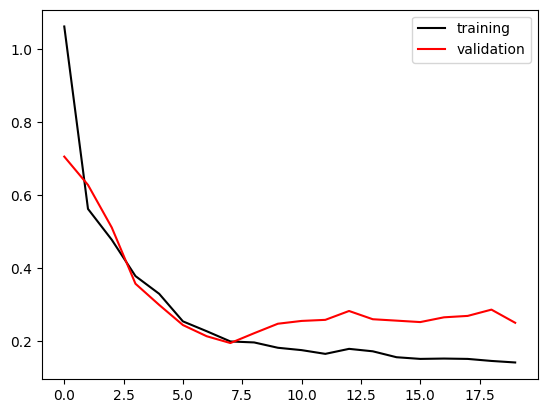

In [ ]:
plt.plot(history.history["mean_squared_error"], c='k', label='training')
plt.plot(history.history["val_mean_squared_error"], c='r', label='validation')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test_scaled.values, y_test_scaled.values, batch_size=y_test_scaled.values.shape[0])
print(results)

Evaluate on test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - loss: 0.2669 - mean_absolute_error: 0.3947 - mean_squared_error: 0.2669 - root_mean_squared_error: 0.5166
[0.2668907046318054, 0.2668907046318054, 0.5166146755218506, 0.39473289251327515]


In [ ]:
# generate predictions using the trained model
predictions = model.predict(X_test_scaled.values)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


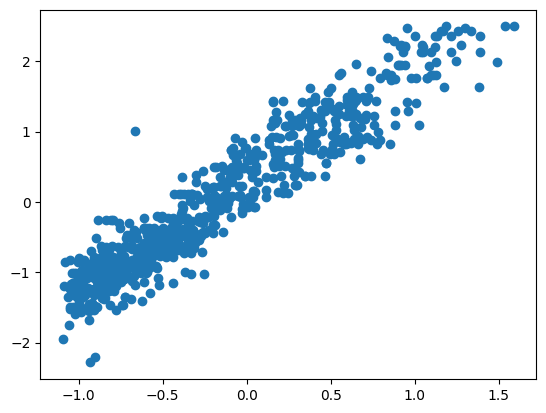

In [ ]:
# visualize predictions vs ground truth
plt.scatter(predictions, y_test_scaled.values)
plt.show()

# Tutorial Practice: How does batch size impact model training?

---

In [ ]:
# recreate the model object

In [ ]:
# recompile the model

In [ ]:
# retrain the model

In [ ]:
# evaluate the new model's skill

Other sample questions for practice:

*   How does the learning rate impact model training?
*   Does data augmentation help with model skill?
*   Does reducing regularization impact overfitting (hint: reduce dropout percentage)?

In [ ]:
# more cells for practicing

# Supervised Learning Classification Example

---

Using our work from the previous section, we will now use the data and reframe our problem to be a classification task. As before, we will use two input features.

However, we will use updraft helicity values (which represent storm updraft rotation) and convert this continuous value into two classes, "not potentially severe" and "potentially severe". More strongly rotating storms have a greater likelihood of producing severe hazards like tornadoes and large hail. We will use 75 m2/s2 as the delineation mark between the two classes. The two classes will be creating using integer encoding first, with 0 representing non-severe and 1 representing potentially severe, and then converting using one-hot encoding for subsequent training.

In [ ]:
# first contactenate multiple feature into one new array along a dim
tmp_dbz = ds['dbz_grid'].expand_dims(dim='feature', axis=3)
tmp_ctt = ds['ctt_grid'].expand_dims(dim='feature', axis=3)

features = xr.concat([tmp_dbz, tmp_ctt], dim='feature')

# make features, x, and y into one column, so that data is (samples, newdim) for train/test split func to work
features_1d = features.stack(newdim=['x','y','feature'])

labels = ds['uh25_grid'].expand_dims(dim='feature', axis=3).max('x').max('y')

# now split train and test data
X_train, X_test, y_train, y_test = train_test_split(features_1d, labels, test_size=0.33, random_state=42)

# unstack the stacked x, y, features dimensions
X_train = X_train.unstack()
X_test = X_test.unstack()

# standardize data
X_train_scaled, scaler_X = scale_da_along_dim(X_train, dim="feature")
X_test_scaled, _ = scale_da_along_dim(X_test, dim="feature", scaler=scaler_X)

# encode the labels as classes (integer encoding)
y_train_scaled = xr.where(y_train >= 75, 1, 0)
y_test_scaled = xr.where(y_test >= 75, 1, 0)

In [ ]:
print(y_train.values[-5:])
print(y_train_scaled.values[-5:])

[[ 92.49213  ]
 [  0.7721376]
 [170.93694  ]
 [  1.3120162]
 [ 17.732342 ]]
[[1]
 [0]
 [1]
 [0]
 [0]]


In [ ]:
# convert labels into classes using one-hot encoding
onehot_layer = keras.layers.CategoryEncoding(num_tokens=2, output_mode="one_hot")
y_train_onehot = onehot_layer(y_train_scaled.astype(int))
y_test_onehot = onehot_layer(y_test_scaled.astype(int))

In [ ]:
y_train_onehot[-5:]

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)>

In [ ]:
# out of more than 1000 samples, only 189 are the "severe" class
print(y_train_onehot[:,1].numpy().sum())
print(y_train_onehot[:,1].numpy().shape)

180.0
(1490,)


Class imbalance is a major issue with a minority class that is a rare event, like severe hazards. To address this limitation, we create class weights that help the machine learning model learn that the minority class is important to get correct.

In [ ]:
# generate class weights due to class imbalance issues
# use the second class as the positive one (using 1 index)
counts = np.bincount(y_train_onehot[:,1].numpy().astype(int))

print("Number of positive samples in training data: {} ({:.2f}% of total)".format(
    counts[1], 100 * float(counts[1]) / len(y_train_onehot[:,1])))

weight_for_0 = counts[1] / len(y_train_onehot[:,1])
weight_for_1 = counts[0] / len(y_train_onehot[:,1])

class_weight = {0: weight_for_0, 1: weight_for_1}
print(class_weight)

Number of positive samples in training data: 180 (12.08% of total)
{0: np.float64(0.12080536912751678), 1: np.float64(0.8791946308724832)}


In [ ]:
# metrics that are useful for classification, particularly for two classes
METRICS = [
    keras.metrics.BinaryCrossentropy(name="binary_crossentropy"),  # same as model's loss
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
model = keras.Sequential()

# input
model.add(keras.Input(shape=(32, 32, number_of_features)))  # 32x32 images

# data augmentation layers
model.add(layers.RandomFlip("horizontal_and_vertical"))
model.add(layers.RandomRotation(factor=(-0.5,0.5)))

# hidden layers
model.add(layers.Conv2D(32, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))
model.add(layers.Dropout(0.2))

# Now that we have 4x4 feature maps, now apply global max pooling.
model.add(layers.GlobalMaxPooling2D())

# Finally, we add last fully connected (dense) layers
model.add(layers.Dense(64))
model.add(layers.Dense(2, activation="softmax"))

# print model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_2 (RandomFlip)      │ (None, 32, 32, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, 32, 32, 2)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_2          │ (None, 128)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,346 (395.88 KB)

 Trainable params: 101,346 (395.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.BinaryCrossentropy(), # categorical loss function
    metrics=METRICS
)

In [ ]:
BATCH_SIZE = 32
EPOCHS = 20

In [ ]:
print("Fit model on training data")
history = model.fit(
    x=X_train_scaled.values,
    y=y_train_onehot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    shuffle=True,
    class_weight=class_weight,
)

Fit model on training data
Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.5538 - auc: 0.6274 - binary_crossentropy: 0.6783 - fn: 302.1395 - fp: 302.1395 - loss: 0.1406 - prc: 0.6361 - precision: 0.5538 - recall: 0.5538 - tn: 400.9767 - tp: 400.9767 - val_accuracy: 0.6309 - val_auc: 0.7784 - val_binary_crossentropy: 0.5524 - val_fn: 55.0000 - val_fp: 55.0000 - val_loss: 0.5524 - val_prc: 0.8077 - val_precision: 0.6309 - val_recall: 0.6309 - val_tn: 94.0000 - val_tp: 94.0000
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 214ms/step - accuracy: 0.6035 - auc: 0.7468 - binary_crossentropy: 0.5636 - fn: 289.5349 - fp: 289.5349 - loss: 0.1107 - prc: 0.7775 - precision: 0.6035 - recall: 0.6035 - tn: 413.5814 - tp: 413.5814 - val_accuracy: 0.7114 - val_auc: 0.8191 - val_binary_crossentropy: 0.4888 - val_fn: 43.0000 - val_fp: 43.0000 - val_loss: 0.4888 - val_prc: 0.8384 - val_precision: 0.7114 - val_recall: 0.7114 - val_tn: 106.0000 - val_tp: 106.0000
Epoch 3/20
42/42 ━━━━━━━━━━━━━━

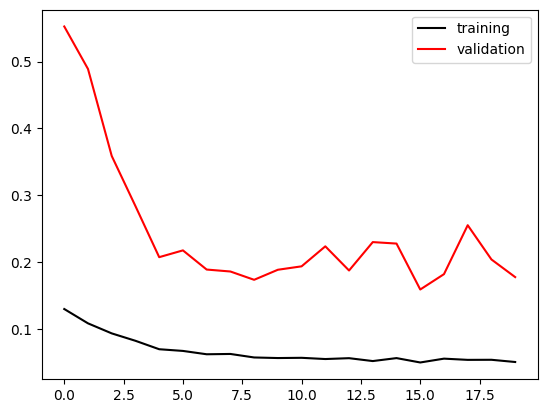

In [ ]:
plt.plot(history.history["loss"], c='k', label='training')
plt.plot(history.history["val_loss"], c='r', label='validation')
plt.legend()
plt.show()

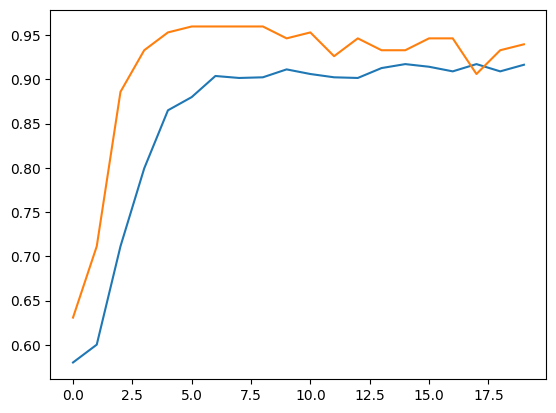

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test_scaled.values, y_test_onehot, batch_size=y_test_onehot.shape[0])
print(results)

Evaluate on test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step - accuracy: 0.9278 - auc: 0.9764 - binary_crossentropy: 0.2073 - fn: 53.0000 - fp: 53.0000 - loss: 0.2073 - prc: 0.9724 - precision: 0.9278 - recall: 0.9278 - tn: 681.0000 - tp: 681.0000
[0.20726722478866577, 0.20726722478866577, 681.0, 53.0, 681.0, 53.0, 0.9277929067611694, 0.9277929067611694, 0.9277929067611694, 0.976370632648468, 0.972446858882904]


In [ ]:
# generate predictions using the trained model
predictions = model.predict(X_test_scaled.values)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


In [ ]:
pred_ints = xr.where(predictions[:,1] > 0.5, 1, 0)

In [ ]:
from sklearn.metrics.cluster import contingency_matrix
contingency_matrix(y_test_onehot[:,1].numpy().astype(int), pred_ints)

array([[591,  42],
       [ 11,  90]])


TP (true positive) = true 1, pred 1 = 90

FN (false negative) = true 1, pred 0 = 11

FP (false positive) = true 0, pred 1 = 42

TN (true negative) = true 0, pred 0 = 591

In [ ]:
y_test_onehot[:,1].numpy().astype(int).sum()

np.int64(101)

In [ ]:
pred_ints.sum() - 101

np.int64(31)

```
y_test_onehot[:,1].sum() = number of actual positives
= TP + FN = 90 + 11 = 101

pred_ints.sum() = number of predicted positives
= TP + FP = 90 + 42 = 132
```
That 31 is not FP itself; it is the net excess of positive predictions over true positives: you have 42 false positives but only 11 false negatives, so you end up predicting 31 more “1”s than are actually present in the ground truth.


# Tutorial Practice: What happens if we do not use class weights during training?

---

In [ ]:
# recreate the model object

In [ ]:
# recompile the model

In [ ]:
# retrain the model without class weights

In [ ]:
# evaluate the new model's skill

# References

Campbell, T., G. M. Lackmann, M. J. Molina, and M. D. Parker (2024). Severe Convective Storms in Limited Instability Organized by Pattern and Distribution. Weather and Forecasting. https://journals.ametsoc.org/view/journals/wefo/39/1/WAF-D-23-0130.1.xml

DuVivier, A. K., M. J. Molina, A. L. Deppenmeier, M. M. Holland, L. Landrum, K. Krumhardt, and S. Jenouvrier (2023). Projections of Winter Polynyas and Their Biophysical Impacts in the Ross Sea Antarctica. Climate Dynamics. https://link.springer.com/article/10.1007/s00382-023-06951-z

Molina, M. J., D. J. Gagne, and A. F. Prein (2021). A benchmark to test generalization capabilities of deep learning methods to classify severe convective storms in a changing climate. Earth and Space Science. https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020EA001490

Molina, M. J., T. A. O'Brien, G. Anderson, M. Ashfaq, K. E. Bennett, W. D. Collins, K. Dagon, J. M. Restrepo, and P. A. Ullrich (2023). A Review of Recent and Emerging Machine Learning Applications for Climate Variability and Weather Phenomena. Artificial Intelligence for the Earth Systems. https://journals.ametsoc.org/view/journals/aies/2/4/AIES-D-22-0086.1.xml

Molina, M. J., J. H. Richter, A. A. Glanville, K. Dagon, J. Berner, A. Hu, and G. A. Meehl (2023). Subseasonal Representation and Predictability of North American Weather Regimes using Cluster Analysis. Artificial Intelligence for the Earth Systems. https://journals.ametsoc.org/view/journals/aies/2/2/AIES-D-22-0051.1.xml

Passarella, L.S. and Mahajan, S., 2023. Assessing Tropical Pacific–Induced Predictability of Southern California Precipitation Using a Novel Multi-Input Multioutput Autoencoder. Artificial Intelligence for the Earth Systems, 2(4), p.e230003. https://journals.ametsoc.org/view/journals/aies/2/4/AIES-D-23-0003.1.xml